In [39]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

import pandas as pd
from modules import drawing as dr
from modules import DataDrop as DD
import numpy as np

import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import SVG
import keras.backend as K
from keras.layers import Input, Dense, LSTM, GRU, Embedding, Activation, Lambda
from keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.utils.vis_utils import model_to_dot
from tqdm import tqdm,trange
from modules.kerosenePreprocess import Kerosene
from modules.DataDrop import supply_data_drop
from modules import statistic_function as sf
from sklearn.metrics import mean_absolute_error
import random
from modules import plotformodel as pfm
from attention import Attention
pd.options.mode.chained_assignment = None  # default='warn'


In [2]:
print(tf.__version__)

2.9.1


In [2]:
# Create dataset(All data) and convert to trainingdata
"""
def create_deepsetdata_Alldata(path):
    kerosene = Kerosene(path)
    # some special id to drop. Apporo dont need this
    kerosene.normal_use.set_index("customer_id", inplace=True)
    kerosene.normal_use.drop([666, 663, 650, 1086], inplace=True)
    kerosene.normal_use.reset_index(inplace=True)
    df = DD.supply_data_drop(kerosene.normal_use.copy())
    # Drop zero
    for i in range(df.shape[0]):
        if df.loc[i, "volume"] == 0:
            df.drop(i, inplace=True)

    df.reset_index(inplace=True, drop=True)
    df.pop("index")
    return df
df = create_deepsetdata_Alldata("./raw_data/2-supply-histories-with-sensor.csv")
df.to_csv("./DeepsetData/pre_normal_season_nozero.csv")
"""
# df = pd.read_csv("./DeepsetData/pre_normal_season_nozero.csv")
df = pd.read_csv("./ClusteringProgram/Hierarchical_data_cc/cluster_2.csv")
df_price = pd.read_csv("./raw_data/kerosene_price.csv")
df_price["date"] = pd.to_datetime(df_price["date"], format="%Y-%m")
df["supplied_at"] = pd.to_datetime(df["supplied_at"], format="%Y-%m-%d %X")
id_unique = pd.unique(df["customer_id"])
sum_mean = sf.Sum_Mean(df, id_unique, "customer_id", "supplied_at", "volume")
df["sum"] = ""
df["mean"] = ""
for id in sum_mean.keys():
    df_id = df[df["customer_id"]==id]
    for year in sum_mean[id].keys():
        for i in df_id.index:
            if df_id.loc[i, "supplied_at"].year == int(year.split("-")[0]) and df_id.loc[i, "supplied_at"].month < 5:
                df.loc[i, "sum"] = sum_mean[id][year][0]
                df.loc[i, "mean"] = sum_mean[id][year][1]
            elif df_id.loc[i, "supplied_at"].year + 1 == int(year.split("-")[0]) and df_id.loc[i, "supplied_at"].month > 10:
                df.loc[i, "sum"] = sum_mean[id][year][0]
                df.loc[i, "mean"] = sum_mean[id][year][1]
# Add last supply time
df["last_supply_time"] = ""
for i in range(0, len(df) - 1):
    if df.loc[i+1, "customer_id"] == df.loc[i, "customer_id"] and (df.loc[i+1, "supplied_at"] - df.loc[i, "supplied_at"]).days < 50:
        df.loc[i+1, "last_supply_time"] = df.loc[i, "supplied_at"]

# Delete data without last supply time
dataset = df.copy()
dataset_final = dataset.copy()
for i in dataset.index:
    if  dataset.loc[i, "last_supply_time"] == "":
        dataset_final.drop(i, inplace=True)
dataset_final.reset_index(inplace=True, drop=True)

# add last year data
dataset_final["last_year_mean"] = ""
dataset_final["last_year_sum"] = ""
unique_id = pd.unique(dataset_final["customer_id"])
for id in unique_id:
    df_id = dataset_final[dataset_final["customer_id"]==id]
    df_id.reset_index(inplace=True)
    for i in range(len(df_id)-1):
        if df_id.loc[i+1, "supplied_at"].month - df_id.loc[i, "supplied_at"].month > 6:
            for j in range(i, len(df_id)-1):
                index = df_id.loc[j, "index"]
                if(df_id.loc[j + 1, "supplied_at"].month - df_id.loc[j, "supplied_at"].month < 3):
                    dataset_final.loc[index, "last_year_mean"] =  df_id.loc[i, "mean"]
                    dataset_final.loc[index, "last_year_sum"] =  df_id.loc[i, "sum"]
# drop data that doesn't contain last year data
for i in dataset_final.index:
    if not isinstance(dataset_final.loc[i, "last_year_mean"], float):
        dataset_final.drop(i, inplace=True)
dataset_final.reset_index(inplace=True, drop=True)

dataset_final["price"] = ""
for i in dataset_final.index:
    for j in df_price.index:
        if (dataset_final.loc[i, "supplied_at"].year == df_price.loc[j, "date"].year and 
        dataset_final.loc[i, "supplied_at"].month == df_price.loc[j, "date"].month):
            dataset_final.loc[i, "price"] = df_price.loc[j, "price"]   


In [2]:
len(pd.unique(dataset_final["customer_id"]))

NameError: name 'dataset_final' is not defined

In [7]:
GROUP_NAME = "highccgroup"
PATH_READ = "./Appolo/A_Dataset/" + GROUP_NAME + "/Train_Test.csv"
PATH_WEATHER = "./raw_data/merged_weatherdata_20220725.csv"

In [8]:
raw_dataset = pd.read_csv(PATH_READ)
dataset = raw_dataset.copy()

dataset["supplied_at"] = pd.to_datetime(dataset["supplied_at"], format="%Y-%m-%d %X")
dataset["last_supply_time"] = pd.to_datetime(dataset["last_supply_time"], format="%Y-%m-%d %X")
#dataset = dataset_final.copy()
df_weather = pd.read_csv(PATH_WEATHER)
df_weather = DD.weather_drop(df_weather) # weather_drop changed date into datetime
df_weather.set_index("date", inplace=True)


day = 24*60*60
year = (365.2425)*day


In [ ]:
# 椿データdrop unusual id
ID_all = pd.unique(dataset["customer_id"])
ID_tanktype = []
for i in ID_all:
    df_id = dataset[dataset["customer_id"] == i]
    df_id.reset_index(inplace=True)
    ID_tanktype.append(df_id.loc[0, "tank_type_id"])
id_over = []
tankid = []
for i in range(len(dataset["volume"])):
    if dataset.loc[i, "volume"] > 500:
        id_over.append(dataset.loc[i, "customer_id"])
        tankid.append(dataset.loc[i, "tank_type_id"])
id_over_unique = pd.unique(pd.Series(id_over))
id_over_unique = list(id_over_unique) #tanktype5
id_over_unique.append(1076)
dataset.set_index("customer_id", inplace=True)
dataset.drop(id_over_unique,inplace=True)
dataset.reset_index(inplace=True)

In [9]:
# Apollo data drop unusual id
ID_all = ID_all = pd.unique(dataset["customer_id"])
id_over = []
tankid = []
for i in range(len(dataset["volume"])):
    if dataset.loc[i, "volume"] > dataset.loc[i, "size"]:
        id_over.append(dataset.loc[i, "customer_id"])
id_over_unique = pd.unique(pd.Series(id_over))
id_over_unique = list(id_over_unique) #tanktype5
dataset.set_index("customer_id", inplace=True)
dataset.drop(id_over_unique,inplace=True)
dataset.reset_index(inplace=True)

In [10]:
# Only use one id
dataset = dataset[dataset["size"] == 446]
dataset.reset_index(inplace=True, drop=True)

In [11]:
id_ls = pd.unique(dataset["customer_id"]) 
len(id_ls)

931

In [12]:
random.seed(1)
id_ls_train = random.sample(list(id_ls), int(0.8*len(id_ls)))

In [13]:
# ID random
train_dataset = dataset[dataset["customer_id"].isin(id_ls_train)]
test_dataset = dataset[~dataset["customer_id"].isin(id_ls_train)]
test_dataset = test_dataset.reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

In [14]:
# Fully random sample
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

test_dataset = test_dataset.reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

In [15]:
len(train_dataset)

2913

In [16]:
len(test_dataset)

728

In [17]:
test_dataset.head()

,customer_id,supplied_at,volume,size,sum,mean,matemp,mltemp,mhtemp,mwind,msnowacc,msnow,msun,mhumidi,mean_consumption,interval,last_supply_time,last_year_mean,last_year_sum,price
0,381.0,2021-11-29 09:05:00,125.6,446,1919.3,17.608257,-5.057143,-1.728571,-8.392857,3.392857,0.214286,0.285714,3.121429,68.000000,8.971429,14.0,2021-11-15 10:12:00,15.561039,2396.4,107
1,381.0,2021-12-29 09:07:00,176.8,446,1919.3,17.608257,5.085714,8.428571,2.271429,3.042857,40.857143,3.428571,4.285714,66.142857,25.257143,7.0,2021-12-22 16:15:00,15.561039,2396.4,112
2,381.0,2022-02-01 13:27:00,276.9,446,1919.3,17.608257,4.020000,7.180000,1.290000,2.190000,88.800000,5.100000,3.550000,72.900000,27.690000,10.0,2022-01-22 13:01:00,15.561039,2396.4,112
3,861.0,2021-12-16 14:11:00,194.1,446,3123.6,23.844275,-3.040000,0.260000,-6.340000,2.650000,1.200000,0.700000,3.620000,70.800000,19.410000,10.0,2021-12-06 12:17:00,23.687333,3553.1,112
4,861.0,2022-01-14 16:17:00,265.4,446,3123.6,23.844275,2.144444,5.266667,-0.355556,4.244444,54.555556,7.333333,2.466667,79.555556,29.488889,9.0,2022-01-05 13:17:00,23.687333,3553.1,107


In [18]:
def planBdataset_tsubaki(test_dataset, df_weather):
    test_data_planB = {}
    test_index_planB = {}
    first_index = 0
    final_index = 0

    for i in range(len(test_dataset)):
        test_data_planB[i] = df_weather.loc[test_dataset.loc[i, "last_supply_time"]: test_dataset.loc[i, "supplied_at"]]
        test_data_planB[i].reset_index(inplace=True)
        test_data_planB[i].drop(columns = ["index"], inplace = True)
        #test_data_planB[i].pop("date")
        # need timedate use this code and comment last line, time is in second
        
        date_time = pd.to_datetime(test_data_planB[i].pop("date"), format="%Y/%m/%d")
        timestamp_s = date_time.map(pd.Timestamp.timestamp)
        test_data_planB[i]['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
        test_data_planB[i]['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))
        
        #test_data_planB[i]["tank_type_id"] = test_dataset.loc[i, "tank_type_id"]
        #test_data_planB[i]["customer_id"] = test_dataset.loc[i, "customer_id"]
        test_data_planB[i]["last_year_mean"] = test_dataset.loc[i, "last_year_mean"]
        test_data_planB[i]["last_year_sum"] = test_dataset.loc[i, "last_year_sum"]
        test_data_planB[i]["price"] = test_dataset.loc[i, "price"]
        first_index = final_index
        final_index += len(test_data_planB[i])
        # Add variable you want in index
        test_index_planB[i] = [test_dataset.loc[i, "supplied_at"], test_dataset.loc[i, "customer_id"], 
                                test_dataset.loc[i, "volume"], test_dataset.loc[i, "tank_type_id"], 
                                test_dataset.loc[i, "interval"], test_dataset.loc[i, "matemp"], 
                                test_dataset.loc[i, "mltemp"], test_dataset.loc[i, "mhtemp"], 
                                first_index, final_index-1]

    # df_testb = pd.concat(test_data_planB)
    # Create index dataframe, columns should be the same in test_index_planb
    df_testb_index = pd.DataFrame.from_dict(test_index_planB, orient='index',
                        columns=["supplied_at","id", 'volume',"tank_type_id", "interval", "matemp", "mltemp", "mhtemp", 'first_index', 'final_index'])
    return test_data_planB, df_testb_index

def planBdataset_appolo(test_dataset, df_weather):
    test_data_planB = {}
    test_index_planB = {}
    first_index = 0
    final_index = 0

    for i in range(len(test_dataset)):
        test_data_planB[i] = df_weather.loc[test_dataset.loc[i, "last_supply_time"]: test_dataset.loc[i, "supplied_at"]]
        test_data_planB[i].reset_index(inplace=True)
        test_data_planB[i].drop(columns = ["index"], inplace = True)
        #test_data_planB[i].pop("date")
        # need timedate use this code and comment last line, time is in second
        
        date_time = pd.to_datetime(test_data_planB[i].pop("date"), format="%Y/%m/%d")
        timestamp_s = date_time.map(pd.Timestamp.timestamp)
        test_data_planB[i]['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
        test_data_planB[i]['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))
        
        #test_data_planB[i]["tank_type_id"] = test_dataset.loc[i, "tank_type_id"]
        #test_data_planB[i]["customer_id"] = test_dataset.loc[i, "customer_id"]
        test_data_planB[i]["last_year_mean"] = test_dataset.loc[i, "last_year_mean"]
        test_data_planB[i]["last_year_sum"] = test_dataset.loc[i, "last_year_sum"]
        test_data_planB[i]["price"] = test_dataset.loc[i, "price"]
        first_index = final_index
        final_index += len(test_data_planB[i])
        # Add variable you want in index
        test_index_planB[i] = [test_dataset.loc[i, "supplied_at"], test_dataset.loc[i, "customer_id"], 
                                test_dataset.loc[i, "volume"], test_dataset.loc[i, "size"], 
                                test_dataset.loc[i, "interval"], test_dataset.loc[i, "matemp"], 
                                test_dataset.loc[i, "mltemp"], test_dataset.loc[i, "mhtemp"], 
                                first_index, final_index-1]

    # df_testb = pd.concat(test_data_planB)
    # Create index dataframe, columns should be the same in test_index_planb
    df_testb_index = pd.DataFrame.from_dict(test_index_planB, orient='index',
                        columns=["supplied_at","id", 'volume', "size", "interval", "matemp", "mltemp", "mhtemp", 'first_index', 'final_index'])
    return test_data_planB, df_testb_index

In [19]:
dic_dataset, dic_dataset_index = planBdataset_appolo(dataset, df_weather)
dic_train, dic_train_index = planBdataset_appolo(train_dataset, df_weather)
dic_test, dic_test_index = planBdataset_appolo(test_dataset, df_weather)


In [20]:
dic_train[1].head()

,atemperature,ltemperature,sunshine,sonw(accumulated),htemperature,snow,windSpeed(m/s),humidity(%),Year sin,Year cos,last_year_mean,last_year_sum,price
0,-2.7,-5.6,4.1,106,0.1,1,3.9,62,0.626939,0.779069,9.010938,1153.4,112
1,-4.3,-8.5,8.0,102,0.0,0,1.2,69,0.640247,0.768169,9.010938,1153.4,112
2,-3.2,-8.5,9.2,98,0.5,0,1.5,68,0.653367,0.757042,9.010938,1153.4,112
3,-2.5,-6.8,7.5,95,1.1,1,2.2,74,0.666292,0.745691,9.010938,1153.4,112
4,-1.0,-3.9,7.1,99,1.5,5,2.8,67,0.679021,0.734119,9.010938,1153.4,112


In [21]:
len(pd.unique(dic_train_index["id"]))

919

In [22]:
def GetMaxFlow(flows):        
    maks=max(flows, key=lambda k: len(flows[k]))
    return len(flows[maks]), maks

In [23]:
GetMaxFlow(dic_dataset)

(50, 2274)

In [24]:
data = list(dic_dataset.values())
label = dic_dataset_index["volume"]

In [25]:
"""
train_data = data[:int(len(data)*0.8)]
test_data = data[int(len(data)*0.8):]

train_label = label[:int(len(label)*0.8)]
test_label = label[int(len(label)*0.8):]
"""

'\ntrain_data = data[:int(len(data)*0.8)]\ntest_data = data[int(len(data)*0.8):]\n\ntrain_label = label[:int(len(label)*0.8)]\ntest_label = label[int(len(label)*0.8):]\n'

In [26]:
train_data = list(dic_train.values())
test_data = list(dic_test.values())
train_label = dic_train_index["volume"]
test_label = dic_test_index["volume"]



In [27]:
# After padding all the data have the same length
padded_train = tf.keras.preprocessing.sequence.pad_sequences(
    train_data, padding="post",dtype='float32', value=-100, maxlen=50
)
padded_test = tf.keras.preprocessing.sequence.pad_sequences(
    test_data, padding="post",dtype='float32', value=-100, maxlen=50
)

In [154]:
X = np.zeros((len(padded_train),42))
m = 0
for i in tqdm(range(len(padded_train)), desc='Generating train examples: '):
    for j in range(1,len(train_data[i])):
        X[i,-j] = m
        m += 1

Generating train examples:  45%|████▍     | 1544/3446 [00:00<00:00, 128169.20it/s]


IndexError: index -43 is out of bounds for axis 1 with size 42

In [23]:
Y = np.zeros((len(padded_test),42))
m = 0
for i in tqdm(range(len(padded_test)), desc='Generating train examples: '):
    for j in range(1,len(test_data[i])):
        Y[i,-j] = m
        m += 1

Generating train examples: 100%|██████████| 448/448 [00:00<00:00, 105192.20it/s]


In [28]:
train_data = pd.concat(train_data)
train_data = train_data.to_numpy()

In [29]:
test_data = pd.concat(test_data)
test_data = test_data.to_numpy()

In [30]:
normalizer = tf.keras.layers.experimental.preprocessing.Normalization(axis=-1)
normalizer.adapt(np.array(train_data))

In [31]:
normalized_data = normalizer(train_data)

print("Features mean: %.2f" % (normalized_data.numpy().mean()))
print("Features std: %.2f" % (normalized_data.numpy().std()))

Features mean: 0.00
Features std: 1.00


In [32]:
def get_deepset_model(images, max_length):
    input_img = Input(shape=(max_length,))
    x = input_img
    x = Embedding(images.shape[0], images.shape[1], mask_zero=True, trainable=False)(input_img)
    x = Dense(300, activation='relu')(x)
    x = Dense(100, activation='relu')(x)
    x = Dense(30, activation='relu')(x)
    Adder = Lambda(lambda x: K.sum(x, axis=1), output_shape=(lambda shape: (shape[0], shape[2])))
    x = Adder(x)
    encoded = Dense(1)(x)
    summer = Model(input_img, encoded)
    adam = Adam(lr=1e-3, epsilon=1e-3)
    summer.compile(optimizer=adam, loss='mae')
    # summer.get_layer(index=1).set_weights([images])
    return summer

In [33]:
def get_lstm_model_nomask(images, max_length,feature_length):
    input_img = Input(shape=(max_length, feature_length))
    x = input_img
    x = normalizer(x)
    x = tf.keras.layers.Masking(mask_value=-100.,
                                input_shape=(max_length, feature_length))(x)
    x = Dense(300, activation='relu')(x)
    x = Dense(100, activation='relu')(x)
    #x = LSTM(50, return_sequences=True)(x)
    #x = Attention(units=30)(x)
    x = LSTM(50)(x)
    x = Dense(30, activation='relu')(x)
    encoded = Dense(1)(x)
    summer = Model(input_img, encoded)
    adam = Adam(lr=1e-3, epsilon=1e-3)
    summer.compile(optimizer=adam, loss='mae')
    return summer

In [42]:
def get_deepset_model_nomask(images, max_length, feature_length):
    input_img = Input(shape=(max_length, feature_length))
    x = input_img
    x = tf.keras.layers.Masking(mask_value=-100.0, input_shape=(max_length, feature_length))(x)
    x = normalizer(x)
    x = Dense(300, activation='relu')(x)
    x = Dense(100, activation='relu')(x)
    x = Dense(30, activation='relu')(x)
    #x = tf.keras.layers.Attention(x)
    #Adder = Lambda(lambda x: K.sum(x, axis=1), output_shape=(lambda shape: (shape[0], shape[2])))
    #x = Adder(x)
    x = Attention(units=30)(x)

    encoded = Dense(1)(x)
    summer = Model(input_img, encoded)
    adam = Adam(lr=1e-3, epsilon=1e-3)
    summer.compile(optimizer=adam, loss='mae')
    return summer

In [76]:
def get_cnn_model_nomask(images, max_length, feature_length):
    # Variable-length int sequences.
    query_input = Input(shape=(max_length, feature_length))
    value_input = Input(shape=(max_length, feature_length))

    # Query encoding of shape [batch_size, Tq, filters].
    query_seq_encoding = Dense(feature_length)(query_input)
    # Value encoding of shape [batch_size, Tv, filters].
    value_seq_encoding = Dense(feature_length)(query_input)

    # Query-value attention of shape [batch_size, Tq, filters].
    query_value_attention_seq = tf.keras.layers.Attention()(
        [query_seq_encoding, value_seq_encoding])
    #Adder = Lambda(lambda x: K.sum(x, axis=1), output_shape=(lambda shape: (shape[0], shape[2])))
    #x = Adder(query_value_attention_seq)
    x = Dense(300, activation='relu')(query_value_attention_seq)
    x = Dense(100, activation='relu')(x)
    x = LSTM(30)(x)
    x = Dense(1)(x)
    summer = Model(inputs=[query_input],  outputs=[x])
    adam = Adam(lr=1e-3, epsilon=1e-3)
    summer.compile(optimizer=adam, loss='mae')
    return summer

In [177]:
# model
K.clear_session()
train = normalizer(train_data)
model = get_deepset_model(train, 15)

# visualize
# keras.utils.plot_model(model, "my_first_model.png",show_shapes=True)
# model.summary()

c:\Users\zhaobang\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# train
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, verbose=1, patience=20, min_lr=0.0001)

history = model.fit(X, train_label, epochs=100, batch_size=10,
        shuffle=True, validation_split=0.1,
        callbacks=[reduce_lr])


# save weights
deep_we = []
for i in [2,3,4,6]:
    w = model.get_layer(index=i).get_weights()
    deep_we.append(w)

In [ ]:
# model
#K.clear_session()
nomaskmodel = get_deepset_model_nomask(train_data, 50, 13)
keras.utils.plot_model(nomaskmodel, "deepset.png", show_shapes=True)


In [ ]:
# train
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, verbose=1, patience=20, min_lr=0.000001)
history = nomaskmodel.fit(padded_train, train_label, epochs=200, batch_size=10,
        shuffle=True, validation_split=0.123456789,
        callbacks=[reduce_lr])

# save weights
nomask = []
for i in [2,3,4,5]:
    w = nomaskmodel.get_layer(index=i).get_weights()
    nomask.append(w)

c:\Users\zhaobang\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


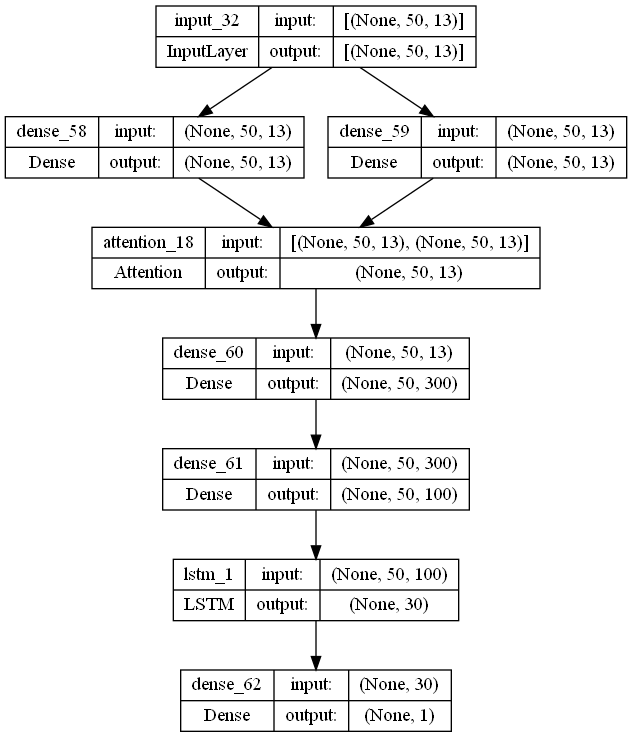

In [77]:
cnnmodel = get_cnn_model_nomask(train_data, 50, 13)
keras.utils.plot_model(cnnmodel, "cnn.png", show_shapes=True)

In [79]:
# train
tf.config.run_functions_eagerly(True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, verbose=1, patience=20, min_lr=0.000001)
history = cnnmodel.fit([padded_train], train_label, epochs=200, batch_size=10,
        shuffle=True, validation_split=0.123456789,
        callbacks=[reduce_lr])

# save weights
cnnw = []
for i in [2,3,4,5]:
    w = cnnmodel.get_layer(index=i).get_weights()
    cnnw.append(w)

Epoch 1/200
256/256 [==============================] - 31s 120ms/step - loss: 212.7897 - val_loss: 211.8976 - lr: 0.0010
Epoch 2/200
256/256 [==============================] - 31s 122ms/step - loss: 208.9610 - val_loss: 207.7704 - lr: 0.0010
Epoch 3/200
 49/256 [====>.........................] - ETA: 24s - loss: 202.9844

KeyboardInterrupt: 

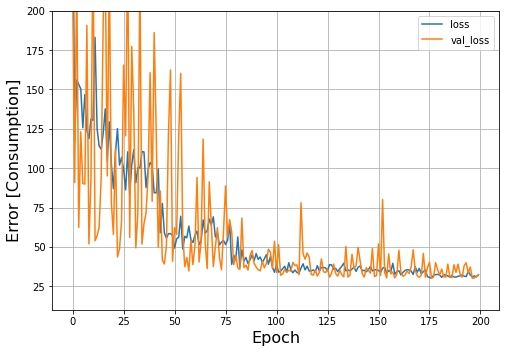

In [72]:
from modules import plotformodel as pfm
pfm.plot_loss(history, lim = [10,200])

In [32]:
print(os.getcwd())

c:\Users\zhaobang\OneDrive\桌面\NewKerosene


In [162]:
nomaskmodel.save_weights("./Appolo/A_model/deepset_tank446L_weight/deepset")

In [30]:
loadedmodel = get_deepset_model_nomask(train_data, 50, 13)

c:\Users\zhaobang\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [31]:
loadedmodel.load_weights("./Appolo/A_model/deepset_tank446L_weight/deepset")
preds = loadedmodel.predict(padded_test, batch_size=1, verbose=1)
MAE = mean_absolute_error(test_label, preds)
print(MAE)

728/728 [==============================] - 1s 1ms/step
22.098059705587534


In [73]:
preds = nomaskmodel.predict(padded_test, batch_size=1, verbose=1)
MAE = mean_absolute_error(test_label, preds)
print(MAE)

728/728 [==============================] - 5s 7ms/step
56.0469883614844


In [41]:
# revert data before and change it back
dic_test_index["matemp"] = -dic_test_index["matemp"].astype(float).round(1)
dic_test_index["mltemp"] = -dic_test_index["mltemp"].astype(float).round(1)
dic_test_index["mhtemp"] = -dic_test_index["mhtemp"].astype(float).round(1)

In [42]:
padded_test.shape

(728, 50, 13)

In [43]:
dic_test_index.head()

,supplied_at,id,volume,size,interval,matemp,mltemp,mhtemp,first_index,final_index
0,2021-11-29 09:05:00,381.0,125.6,446,14.0,5.1,1.7,8.4,0,13
1,2021-12-29 09:07:00,381.0,176.8,446,7.0,-5.1,-8.4,-2.3,14,20
2,2022-02-01 13:27:00,381.0,276.9,446,10.0,-4.0,-7.2,-1.3,21,30
3,2021-12-16 14:11:00,861.0,194.1,446,10.0,3.0,-0.3,6.3,31,40
4,2022-01-14 16:17:00,861.0,265.4,446,9.0,-2.1,-5.3,0.4,41,49


In [44]:
unique_id_test = pd.unique(dic_test_index["id"])

In [45]:
new_year_index = []
for i in range(len(dic_test_index)):
    if dic_test_index.loc[i, "supplied_at"].month == 1 and dic_test_index.loc[i, "supplied_at"].day <= 15:
        new_year_index.append(i)

In [46]:
dic_test_index.head()

,supplied_at,id,volume,size,interval,matemp,mltemp,mhtemp,first_index,final_index
0,2021-11-29 09:05:00,381.0,125.6,446,14.0,5.1,1.7,8.4,0,13
1,2021-12-29 09:07:00,381.0,176.8,446,7.0,-5.1,-8.4,-2.3,14,20
2,2022-02-01 13:27:00,381.0,276.9,446,10.0,-4.0,-7.2,-1.3,21,30
3,2021-12-16 14:11:00,861.0,194.1,446,10.0,3.0,-0.3,6.3,31,40
4,2022-01-14 16:17:00,861.0,265.4,446,9.0,-2.1,-5.3,0.4,41,49


In [47]:
preds = preds.reshape(728, )

In [48]:
preds = pd.Series(preds, name="予測値")
erro =  preds - test_label
erro_per = erro / test_label
preds = preds.astype(float).round(1)
erro = erro.astype(float).round(1)
erro_per = erro_per.astype(float).round(3)
sf.error_distribution(erro_per)

>-0.2 and <=0: 0.2802197802197802
<0.2 and >0: 0.18818681318681318
>0.2: 0.3076923076923077
<-0.2: 0.2239010989010989


In [44]:
dic_test_index["preds"] = preds

In [45]:
testid = pd.unique(dic_test_index["id"])

In [46]:
testid

array([3.810000e+02, 8.610000e+02, 9.410000e+02, 1.101000e+03,
       1.181000e+03, 1.461000e+03, 1.611000e+03, 1.901000e+03,
       1.981000e+03, 2.161000e+03, 2.541000e+03, 2.551000e+03,
       2.651000e+03, 2.731000e+03, 2.801000e+03, 2.851000e+03,
       2.971000e+03, 3.051000e+03, 3.241000e+03, 3.271000e+03,
       3.611000e+03, 3.621000e+03, 3.631000e+03, 3.641000e+03,
       3.651000e+03, 3.731000e+03, 3.821000e+03, 3.831000e+03,
       3.911000e+03, 5.181000e+03, 5.201000e+03, 5.391000e+03,
       5.591000e+03, 5.611000e+03, 5.621000e+03, 5.631000e+03,
       6.241000e+03, 6.251000e+03, 6.671000e+03, 7.261000e+03,
       7.281000e+03, 7.601000e+03, 7.901000e+03, 8.011000e+03,
       8.201000e+03, 8.281000e+03, 8.411000e+03, 8.591000e+03,
       8.751000e+03, 9.261000e+03, 1.007000e+05, 1.009000e+05,
       1.028000e+05, 1.041500e+05, 2.009000e+05, 3.002000e+05,
       3.050000e+05, 3.055010e+05, 5.005000e+05, 5.006000e+05,
       5.011000e+05, 5.031000e+05, 5.047000e+05, 5.9990

In [47]:
id_test = dic_test_index[dic_test_index["id"] == 637]

In [54]:
time = id_test["supplied_at"]
refuel = id_test["volume"]
prediction = id_test["preds"]

NameError: name 'id_test' is not defined

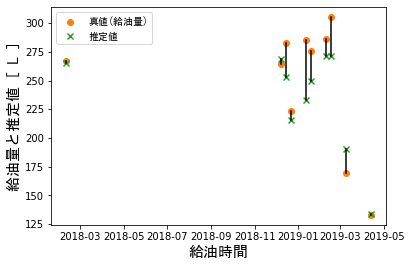

In [53]:
fig, ax = plt.subplots()
#line1, = ax.plot(time, refuel)
scatter1= ax.scatter(time, refuel, color="#ff7f0e", marker='o')
#line2, = ax.plot(time, prediction, color="#d62728")
scatter2= ax.scatter(time, prediction, color="#2ca02c", marker='x')

ax.plot((time,time),(refuel, prediction),c='black')
plt.xlabel("給油時間", fontsize=15, fontname="MS Gothic")
plt.ylabel("給油量と推定値 [ L ]", fontsize=15, fontname="MS Gothic")
ax.legend([scatter1, scatter2], ['真値(給油量)','推定値'], prop={"family":"MS Gothic"})


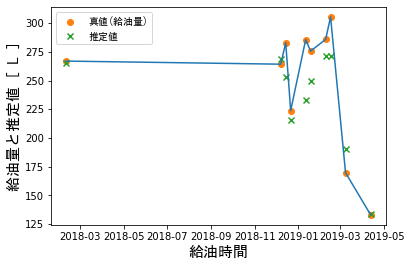

In [54]:
fig, ax = plt.subplots()
line1, = ax.plot(time, refuel)
scatter1= ax.scatter(time, refuel, color="#ff7f0e", marker='o')
#line2, = ax.plot(time, prediction, color="#d62728")
scatter2= ax.scatter(time, prediction, color="#2ca02c", marker='x')

plt.xlabel("給油時間", fontsize=15, fontname="MS Gothic")
plt.ylabel("給油量と推定値 [ L ]", fontsize=15, fontname="MS Gothic")
ax.legend([scatter1, scatter2], ['真値(給油量)','推定値'], prop={"family":"MS Gothic"})

In [48]:
dic_test_index.head()

,supplied_at,id,volume,size,interval,matemp,mltemp,mhtemp,first_index,final_index,preds
0,2021-11-29 09:05:00,381.0,125.6,446,14.0,5.1,1.7,8.4,0,13,152.5
1,2021-12-29 09:07:00,381.0,176.8,446,7.0,-5.1,-8.4,-2.3,14,20,137.6
2,2022-02-01 13:27:00,381.0,276.9,446,10.0,-4.0,-7.2,-1.3,21,30,193.3
3,2021-12-16 14:11:00,861.0,194.1,446,10.0,3.0,-0.3,6.3,31,40,179.3
4,2022-01-14 16:17:00,861.0,265.4,446,9.0,-2.1,-5.3,0.4,41,49,255.5


In [49]:
interval = dic_test_index["interval"]
tank_type_id = dic_test_index["size"]
customer_id = dic_test_index["id"]
supplied_at = dic_test_index["supplied_at"]
matemp = dic_test_index["matemp"]
mltemp = dic_test_index["mltemp"]
mhtemp = dic_test_index["mhtemp"]

In [50]:
test_label_s = test_label.rename("真値(給油量L)")
erro_s = erro.rename("誤差(予測-真値)")
erro_per_s = erro_per.rename("EE((予測-真値)/真値)")

In [51]:
preds

0      152.5
1      137.6
2      193.3
3      179.3
4      255.5
       ...  
723    130.2
724    386.6
725    374.6
726    160.8
727    203.9
Name: 予測値, Length: 728, dtype: float64

In [52]:
df_erro = pd.concat([customer_id, supplied_at, preds, test_label_s, erro_s, erro_per_s, interval, matemp, mltemp, mhtemp,tank_type_id], axis=1)

In [53]:
# 椿データ
df_erro["タンク容量"] = ""
for i in range(len(df_erro["tank_type_id"])):
    if df_erro.loc[i, "tank_type_id"] == 1:
        df_erro.loc[i,"タンク容量"] = 496
    elif df_erro.loc[i, "tank_type_id"] == 3:
        df_erro.loc[i, "タンク容量"] =500
df_erro["tank_type_id"].value_counts()

KeyError: 'tank_type_id'

In [ ]:
#椿データ
df_erro["推定の残量"] = ""
df_erro["実際の残量"] = ""
df_erro["推定残日数"] = ""
df_erro["可能な残日数"] = ""

for i in range(len(df_erro)):
    means_consumption_pred = df_erro.loc[i, "予測値"] / df_erro.loc[i, "interval"]
    left_kerosene_pred = df_erro.loc[i, "タンク容量"] - df_erro.loc[i, "予測値"]
    left_days_pred = left_kerosene_pred / means_consumption_pred

    means_consumption = df_erro.loc[i, "真値(給油量L)"] / df_erro.loc[i, "interval"]
    left_kerosene = df_erro.loc[i, "タンク容量"] - df_erro.loc[i, "真値(給油量L)"]
    left_days = left_kerosene / means_consumption

    df_erro.loc[i, "推定の残量"] = left_kerosene_pred
    df_erro.loc[i, "実際の残量"] = left_kerosene
    df_erro.loc[i, "推定残日数"] = round(left_days_pred, 1)
    df_erro.loc[i, "可能な残日数"] = round(left_days, 1)



In [54]:
#　Appoloデータ
df_erro["推定の残量"] = ""
df_erro["実際の残量"] = ""
df_erro["推定残日数"] = ""
df_erro["可能な残日数"] = ""

for i in range(len(df_erro)):
    means_consumption_pred = df_erro.loc[i, "予測値"] / df_erro.loc[i, "interval"]
    left_kerosene_pred = df_erro.loc[i, "size"] - df_erro.loc[i, "予測値"]
    left_days_pred = left_kerosene_pred / means_consumption_pred

    means_consumption = df_erro.loc[i, "真値(給油量L)"] / df_erro.loc[i, "interval"]
    left_kerosene = df_erro.loc[i, "size"] - df_erro.loc[i, "真値(給油量L)"]
    left_days = left_kerosene / means_consumption

    df_erro.loc[i, "推定の残量"] = left_kerosene_pred
    df_erro.loc[i, "実際の残量"] = left_kerosene
    df_erro.loc[i, "推定残日数"] = round(left_days_pred, 1)
    df_erro.loc[i, "可能な残日数"] = round(left_days, 1)


In [55]:
df_erro.tail()

,id,supplied_at,予測値,真値(給油量L),誤差(予測-真値),EE((予測-真値)/真値),interval,matemp,mltemp,mhtemp,size,タンク容量,推定の残量,実際の残量,推定残日数,可能な残日数
723,8620000.0,2021-12-30 11:36:00,130.2,142.7,-12.5,-0.088,20.0,-2.0,-5.1,0.9,446,,315.8,303.3,48.5,42.5
724,8620350.0,2022-01-17 11:43:00,386.6,364.4,22.2,0.061,31.0,-3.4,-6.5,-0.6,446,,59.4,81.6,4.8,6.9
725,8620350.0,2022-02-18 15:37:00,374.6,378.1,-3.5,-0.009,32.0,-3.5,-7.0,-0.3,446,,71.4,67.9,6.1,5.7
726,8621360.0,2021-12-13 10:19:00,160.8,87.3,73.5,0.842,16.0,3.7,-0.4,7.6,446,,285.2,358.7,28.4,65.7
727,8622750.0,2022-01-11 15:30:00,203.9,241.6,-37.7,-0.156,17.0,-4.7,-8.2,-1.5,446,,242.1,204.4,20.2,14.4


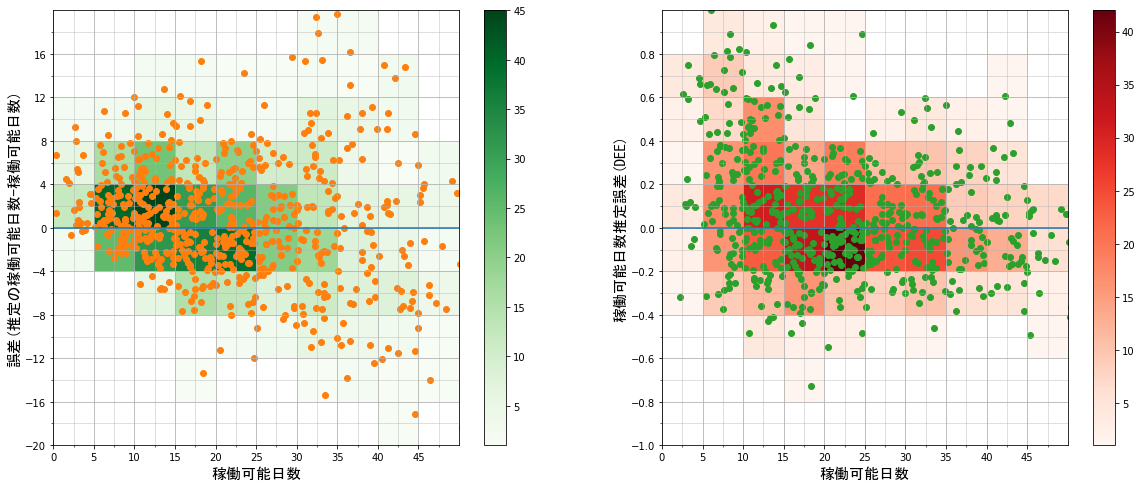

In [56]:
plt.rcParams['figure.figsize'] = [20, 8]
fig, ax = plt.subplots(1,2)
# ax[1] = fig.add_subplot(122,projection='3d')

# Make data.
X = df_erro["可能な残日数"]
Y = df_erro["推定残日数"]
N = df_erro["推定の残量"]
M = df_erro["実際の残量"]


Z = Y - X
K = (Y - X)/X

major_ticks_ax_x = np.arange(0, 50, 5)
minor_ticks_ax_x = np.arange(0, 50, 2.5)

major_ticks_ax0_y = np.arange(-20, 20, 4)
minor_ticks_ax0_y = np.arange(-20, 20, 2)
major_ticks_ax1_y = np.arange(-1, 1, 0.2)
minor_ticks_ax1_y = np.arange(-1, 1, 0.1)

ax[0].set_ylim([-20,20])
ax[0].set_xlim([0, 50])
ax[0].set_xticks(major_ticks_ax_x)
ax[0].set_xticks(minor_ticks_ax_x, minor=True)
ax[0].set_yticks(major_ticks_ax0_y)
ax[0].set_yticks(minor_ticks_ax0_y, minor=True)


img0 = ax[0].hist2d(X, Z, bins=[10, 10], range=[[0, 50],[-20, 20]], cmap=plt.cm.Greens, cmin=1)
fig.colorbar(img0[3], ax=ax[0])
ax[0].scatter(X, Z, color="#ff7f0e")
ax[0].axhline(y=0, color='#1f77b4', linestyle='-')
ax[0].set_xlabel('稼働可能日数', fontname="MS Gothic", fontsize=15)
ax[0].set_ylabel('誤差(推定の稼働可能日数-稼働可能日数)', fontname="MS Gothic", fontsize=15)
ax[0].grid(which='minor', alpha=0.5)
ax[0].grid(which='major', alpha=1.0)


ax[1].set_xticks(major_ticks_ax_x)
ax[1].set_xticks(minor_ticks_ax_x, minor=True)
ax[1].set_yticks(major_ticks_ax1_y)
ax[1].set_yticks(minor_ticks_ax1_y, minor=True)
ax[1].set_ylim([-1,1])
ax[1].set_xlim([0, 50])

img1 = ax[1].hist2d(X, K, bins=[10, 10], range=[[0, 50],[-1, 1]], cmap=plt.cm.Reds, cmin=1)
fig.colorbar(img1[3], ax=ax[1])
ax[1].scatter(X, K, color="#2ca02c")
ax[1].axhline(y=0, color='#1f77b4', linestyle='-')
ax[1].set_xlabel('稼働可能日数', fontname="MS Gothic", fontsize=15)
ax[1].set_ylabel('稼働可能日数推定誤差(DEE)', fontname="MS Gothic", fontsize=15)
ax[1].grid(which='minor', alpha=0.5)
ax[1].grid(which='major', alpha=1.0)


In [57]:
left_days_intger = []
for i in df_erro["可能な残日数"]:
    left_days_intger.append(i)
left_days_intger = pd.Series(left_days_intger)

In [58]:
left_days_intger = left_days_intger.round()

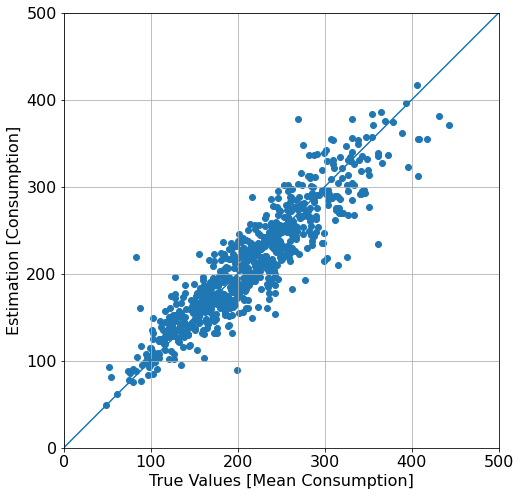

In [59]:
pfm.plot_meanAndsum(df_erro["真値(給油量L)"], df_erro["予測値"], lims=[0, 500])

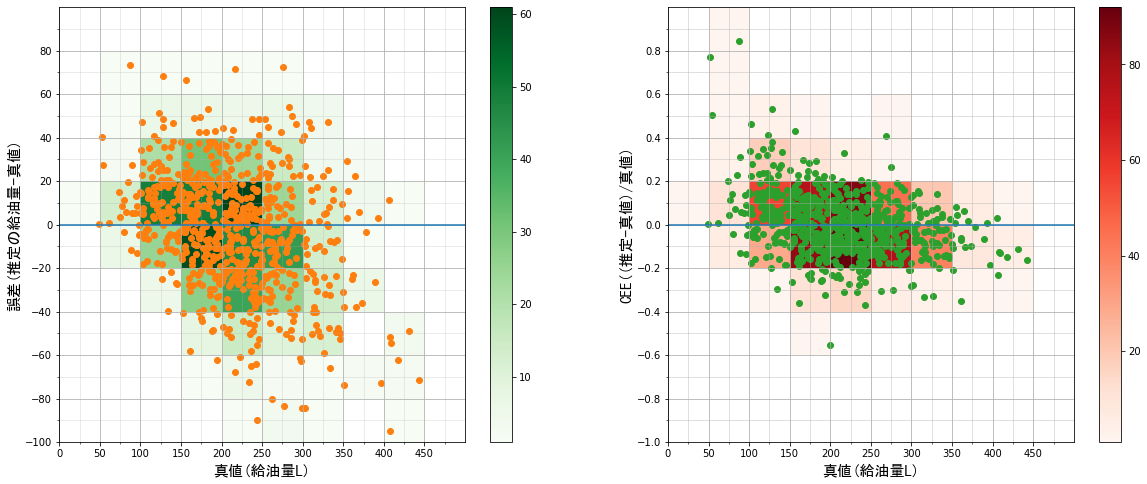

In [60]:
plt.rcParams['figure.figsize'] = [20, 8]
fig, ax = plt.subplots(1,2)
# ax[1] = fig.add_subplot(122,projection='3d')

# Make data.
X = df_erro["真値(給油量L)"]
Y = df_erro["予測値"]
Z = df_erro["誤差(予測-真値)"]
Z2 = df_erro["EE((予測-真値)/真値)"]



major_ticks_ax_x = np.arange(0, 500, 50)
minor_ticks_ax_x = np.arange(0, 500, 25)

major_ticks_ax0_y = np.arange(-100, 100, 20)
minor_ticks_ax0_y = np.arange(-100, 100, 10)
major_ticks_ax1_y = np.arange(-1, 1, 0.2)
minor_ticks_ax1_y = np.arange(-1, 1, 0.1)

ax[0].set_ylim([-100,100])
ax[0].set_xlim([0, 500])
ax[1].set_ylim([-1,1])
ax[1].set_xlim([0, 500])

ax[0].set_xticks(major_ticks_ax_x)
ax[0].set_xticks(minor_ticks_ax_x, minor=True)
ax[0].set_yticks(major_ticks_ax0_y)
ax[0].set_yticks(minor_ticks_ax0_y, minor=True)


# Plot the surface.
img0 = ax[0].hist2d(X, Z, bins=[10, 10], range=[[0, 500],[-100, 100]], cmap=plt.cm.Greens, cmin=1)
fig.colorbar(img0[3], ax=ax[0])
ax[0].scatter(X, Z, color="#ff7f0e")
ax[0].axhline(y=0, color='#1f77b4', linestyle='-')
ax[0].set_xlabel('真値(給油量L)', fontname="MS Gothic",  fontsize=15)
ax[0].set_ylabel('誤差(推定の給油量-真値)', fontname="MS Gothic",  fontsize=15)
ax[0].grid(which='minor', alpha=0.3)
ax[0].grid(which='major', alpha=1.0)



ax[1].set_xticks(major_ticks_ax_x)
ax[1].set_xticks(minor_ticks_ax_x, minor=True)
ax[1].set_yticks(major_ticks_ax1_y)
ax[1].set_yticks(minor_ticks_ax1_y, minor=True)

img1 = ax[1].hist2d(X, Z2, bins=[10, 10], range=[[0, 500],[-1, 1]], cmap=plt.cm.Reds, cmin=1)
fig.colorbar(img1[3], ax=ax[1])
ax[1].scatter(X, Z2, color="#2ca02c")
ax[1].axhline(y=0, color='#1f77b4', linestyle='-')
ax[1].set_xlabel('真値(給油量L)', fontname="MS Gothic",  fontsize=15)
ax[1].set_ylabel('CEE((推定-真値)/真値)', fontname="MS Gothic",  fontsize=15)
ax[1].grid(which='minor', alpha=0.5)
ax[1].grid(which='major', alpha=1.0)

# ax[1].azim = 260
# ax[1].elev = 5

In [55]:
df_erro["残日数EE"] = ((df_erro["推定残日数"] - df_erro["可能な残日数"])/df_erro["可能な残日数"]).astype(float).round(3)

In [56]:
df_erro.head()

,id,supplied_at,予測値,真値(給油量L),誤差(予測-真値),EE((予測-真値)/真値),interval,matemp,mltemp,mhtemp,size,推定の残量,実際の残量,推定残日数,可能な残日数,残日数EE
0,451.0,2022-01-05 12:12:00,127.2,121.0,6.2,0.051,7.0,-5.4,-8.3,-2.0,446,318.8,325.0,17.5,18.8,-0.069
1,451.0,2022-01-20 15:19:00,220.7,232.4,-11.7,-0.050,15.0,-2.0,-5.1,0.7,446,225.3,213.6,15.3,13.8,0.109
2,451.0,2022-02-26 11:07:00,294.4,306.3,-11.9,-0.039,21.0,-2.1,-5.6,1.0,446,151.6,139.7,10.8,9.6,0.125
3,861.0,2021-12-06 12:17:00,256.8,279.0,-22.2,-0.080,14.0,3.5,-0.2,7.0,446,189.2,167.0,10.3,8.4,0.226
4,861.0,2022-01-24 17:34:00,275.6,289.6,-14.0,-0.048,10.0,-2.4,-6.0,0.4,446,170.4,156.4,6.2,5.4,0.148


In [57]:
len(pd.unique(df_erro["id"]))

504

In [58]:
len(df_erro[df_erro["真値(給油量L)"]>=200])

417

In [59]:
len(df_erro[df_erro["真値(給油量L)"]>=223])

324

In [60]:
# For refuel in new year
new_year_index = []
for i in range(len(df_erro)):
     if df_erro.loc[i, "supplied_at"].month == 1 and df_erro.loc[i, "supplied_at"].day <= 15:
        new_year_index.append(i)
df_new_year = df_erro.iloc[new_year_index]
MAE = mean_absolute_error(df_new_year["予測値"], df_new_year["真値(給油量L)"])
print(MAE)

24.624786324786328


In [61]:
test_id = pd.unique(df_erro["id"])

In [62]:
# Find the first refuel index
new_year_index = []
for id in test_id:
    df_id = df_erro[df_erro["id"] == id]
    for i in df_id.index:
        if df_id.loc[i, "supplied_at"].month == 1 and df_id.loc[i, "supplied_at"].day - df_id.loc[i, "interval"] <= 0:
            new_year_index.append(i)
df_new_year = df_erro.iloc[new_year_index]
MAE = mean_absolute_error(df_new_year["予測値"], df_new_year["真値(給油量L)"])
print(MAE)

24.44240837696335


In [63]:
len(df_new_year)

191

In [64]:
len(pd.unique(df_new_year["id"]))

191

In [65]:
# Find the second refuel index
new_year__second_index = []
for id in test_id:
    df_id_test = df_erro[df_erro["id"] == id]
    df_id_all = dataset[dataset["customer_id"] == id]
    for i in df_id_test.index:
        if df_id_test.loc[i, "supplied_at"].month == 1:
            day = df_id_test.loc[i, "supplied_at"].day - df_id_test.loc[i, "interval"]
            if(day > 0):
                for j in df_id_all.index:
                    if df_id_all.loc[j, "supplied_at"].year == df_id_test.loc[i, "supplied_at"].year and df_id_all.loc[j, "supplied_at"].month == 1 and df_id_all.loc[j, "supplied_at"].day == day and df_id_all.loc[j, "supplied_at"].day - df_id_all.loc[j, "interval"] <= 0:
                        new_year__second_index.append(i)

df_new_year_second = df_erro.iloc[new_year__second_index]
MAE = mean_absolute_error(df_new_year_second["予測値"], df_new_year_second["真値(給油量L)"])
print(MAE)

22.876363636363642


In [101]:
df_new_year_second.to_csv("./unusual_id/new_year_second.csv", encoding='utf_8_sig')

In [66]:
len(pd.unique(df_new_year_second["id"]))

55

In [67]:
len(df_new_year_second)

55

In [68]:
dataset.head()

,customer_id,supplied_at,volume,size,sum,mean,matemp,mltemp,mhtemp,mwind,msnowacc,msnow,msun,mhumidi,mean_consumption,interval,last_supply_time,last_year_mean,last_year_sum,price
0,381.0,2021-11-29 09:05:00,125.6,446,1919.3,17.608257,-5.057143,-1.728571,-8.392857,3.392857,0.214286,0.285714,3.121429,68.000000,8.971429,14.0,2021-11-15 10:12:00,15.561039,2396.4,107
1,381.0,2021-12-09 13:25:00,107.7,446,1919.3,17.608257,-3.670000,0.470000,-7.400000,3.430000,2.300000,1.400000,4.120000,72.000000,10.770000,10.0,2021-11-29 09:05:00,15.561039,2396.4,112
2,381.0,2021-12-22 16:15:00,173.3,446,1919.3,17.608257,-0.253846,2.892308,-3.284615,2.961538,20.846154,5.692308,2.915385,73.538462,13.330769,13.0,2021-12-09 13:25:00,15.561039,2396.4,112
3,381.0,2021-12-29 09:07:00,176.8,446,1919.3,17.608257,5.085714,8.428571,2.271429,3.042857,40.857143,3.428571,4.285714,66.142857,25.257143,7.0,2021-12-22 16:15:00,15.561039,2396.4,112
4,381.0,2022-01-06 13:02:00,187.6,446,1919.3,17.608257,5.375000,8.287500,2.037500,3.950000,41.500000,3.375000,2.337500,71.250000,23.450000,8.0,2021-12-29 09:07:00,15.561039,2396.4,107


In [74]:
dataset[dataset["customer_id"] == 637].to_csv("./unusual_id/637.csv", encoding='utf_8_sig')

In [78]:
df_new_year.to_csv("./unusual_id/new_year.csv", encoding='utf_8_sig')

In [69]:
max(df_erro["interval"])

43.0

In [70]:
# For refuel with long interval
def calculate_MAE_longinterval(df_erro, interval_shrehold):
    long_interval_index = []
    for i in range(len(df_erro)):
        if df_erro.loc[i, "interval"] >=interval_shrehold:
                long_interval_index.append(i)
    df_long_interval = df_erro.iloc[long_interval_index]
    long_interval_length = len(df_long_interval)
    MAE = mean_absolute_error(df_long_interval["予測値"], df_long_interval["真値(給油量L)"])
    return MAE, long_interval_length

# For refuel with long interval
def calculate_MAE_shortinterval(df_erro, interval_shrehold):
    short_interval_index = []
    for i in range(len(df_erro)):
        if df_erro.loc[i, "interval"] < interval_shrehold:
                short_interval_index.append(i)
    df_short_interval = df_erro.iloc[short_interval_index]
    short_interval_length = len(df_short_interval)
    MAE = mean_absolute_error(df_short_interval["予測値"], df_short_interval["真値(給油量L)"])
    return MAE, short_interval_length

In [71]:
# for a specific interval shrehold
long_interval_index_ex = []
for i in range(len(df_erro)):
    if df_erro.loc[i, "interval"] >= 30:
            long_interval_index_ex.append(i)
df_long_interval_ex = df_erro.iloc[long_interval_index_ex]
mean_absolute_error(df_long_interval_ex["予測値"], df_long_interval_ex["真値(給油量L)"])

22.101388888888888

In [72]:
len(pd.unique(df_long_interval_ex["id"]))

129

In [73]:
MAEs_long =[]
MAEs_short = []
long_interval_length = []
short_interval_length = []
for i in range(5, 43):
    mae,length = calculate_MAE_longinterval(df_erro, i)
    long_interval_length.append(length)
    MAEs_long.append(mae)
    
    mae,length = calculate_MAE_shortinterval(df_erro, i)
    short_interval_length.append(length)
    MAEs_short.append(mae)

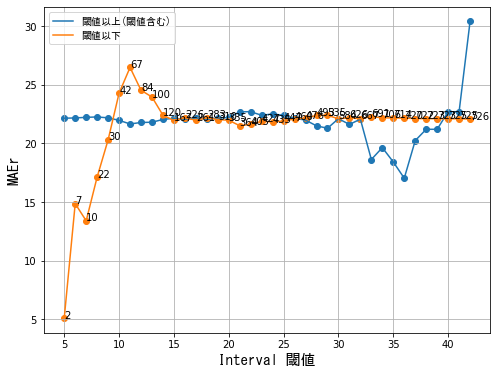

In [74]:
plt.rcParams['figure.figsize'] = [8, 6]
fig, ax = plt.subplots(1, 1)
x = range(5, 43)
interval_long, = ax.plot(x, MAEs_long)
ax.scatter(x, MAEs_long)
interval_short, = ax.plot(x, MAEs_short)
ax.scatter(x, MAEs_short)
ax.legend([interval_long, interval_short], ['閾値以上(閾値含む)','閾値以下'], prop={"family":"MS Gothic"})
plt.xlabel("Interval 閾値", fontname="MS Gothic",  fontsize=15)
plt.ylabel("MAEr", fontname="MS Gothic",  fontsize=15)

# for i, txt in enumerate(long_interval_length):
#     plt.annotate(txt, (x[i], MAEs_long[i]))

for i, txt in enumerate(short_interval_length):
    plt.annotate(txt, (x[i], MAEs_short[i]))


plt.grid(True)


In [105]:
def interval_distribution(df):
    interval_unique = df["interval"].value_counts()
    plt.xlim =[0, 50]
    plt.bar(interval_unique.index, interval_unique)
    
    plt.xlabel("Interval", fontname="MS Gothic",  fontsize=15)
    plt.ylabel("件数", fontname="MS Gothic",  fontsize=15)


In [76]:
pd.unique(dataset["customer_id"])

array([3.810000e+02, 4.510000e+02, 8.610000e+02, 8.810000e+02,
       9.410000e+02, 9.610000e+02, 1.001000e+03, 1.041000e+03,
       1.101000e+03, 1.181000e+03, 1.281000e+03, 1.321000e+03,
       1.461000e+03, 1.611000e+03, 1.901000e+03, 1.981000e+03,
       2.161000e+03, 2.221000e+03, 2.241000e+03, 2.341000e+03,
       2.371000e+03, 2.541000e+03, 2.551000e+03, 2.651000e+03,
       2.731000e+03, 2.801000e+03, 2.851000e+03, 2.891000e+03,
       2.941000e+03, 2.971000e+03, 3.051000e+03, 3.111000e+03,
       3.241000e+03, 3.271000e+03, 3.451000e+03, 3.531000e+03,
       3.611000e+03, 3.621000e+03, 3.631000e+03, 3.641000e+03,
       3.651000e+03, 3.731000e+03, 3.821000e+03, 3.831000e+03,
       3.911000e+03, 4.881000e+03, 5.181000e+03, 5.201000e+03,
       5.231000e+03, 5.391000e+03, 5.571000e+03, 5.591000e+03,
       5.611000e+03, 5.621000e+03, 5.631000e+03, 5.751000e+03,
       6.241000e+03, 6.251000e+03, 6.631000e+03, 6.671000e+03,
       6.871000e+03, 7.251000e+03, 7.261000e+03, 7.2810

In [90]:
example_id = dataset[dataset["customer_id"] == 7901]

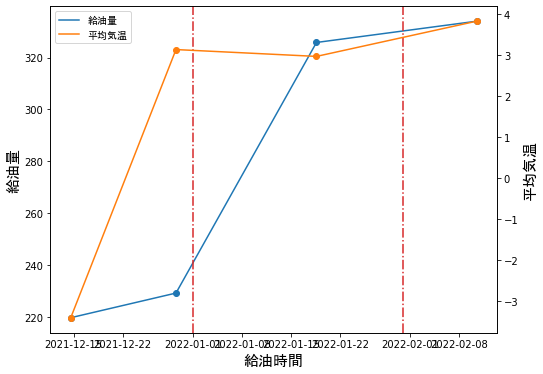

In [91]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
line1, = ax1.plot(example_id["supplied_at"], example_id["volume"])
ax1.scatter(example_id["supplied_at"], example_id["volume"])
ax1.axvline(x=pd.to_datetime('2022-1-01'), color='#d62728', linestyle='dashdot')
ax1.axvline(x=pd.to_datetime('2022-1-31'), color='#d62728', linestyle='dashdot')
line2, = ax2.plot(example_id["supplied_at"], example_id["matemp"], color="#ff7f0e")
ax2.scatter(example_id["supplied_at"], example_id["matemp"], color="#ff7f0e")
ax1.set_xlabel("給油時間", fontname="MS Gothic",  fontsize=15)
ax1.set_ylabel("給油量", fontname="MS Gothic",  fontsize=15)
ax2.set_ylabel("平均気温", fontname="MS Gothic",  fontsize=15)
ax1.legend([line1, line2], ['給油量','平均気温'], prop={"family":"MS Gothic"})

In [ ]:
interval_distribution(dataset)

In [ ]:
interval_distribution(test_dataset)

In [ ]:
interval_distribution(train_dataset)

In [114]:
# Drop new year and long interval refuel
long_interval_index = []
for i in range(len(df_erro)):
    if df_erro.loc[i, "interval"] >=30:
            long_interval_index.append(i)
big_error_index = new_year_index + long_interval_index
big_error_set = set(big_error_index)
big_error_index_unique = list(big_error_set)
df_drop_big_error = df_erro.drop(big_error_index_unique)
MAE = mean_absolute_error(df_drop_big_error["予測値"], df_drop_big_error["真値(給油量L)"])
print(MAE)


21.48165938864629


In [111]:
len(pd.unique(df_erro["id"]))

504

In [112]:
len(df_drop_big_error)

458

In [113]:
len(pd.unique(df_drop_big_error["id"]))

323

In [120]:
df_erro.head()

,id,supplied_at,予測値,真値(給油量L),誤差(予測-真値),EE((予測-真値)/真値),interval,matemp,mltemp,mhtemp,size,推定の残量,実際の残量,推定残日数,可能な残日数,残日数EE
0,451.0,2022-01-05 12:12:00,127.2,121.0,6.2,0.051,7.0,-5.4,-8.3,-2.0,446,318.8,325.0,17.5,18.8,-0.069
1,451.0,2022-01-20 15:19:00,220.7,232.4,-11.7,-0.050,15.0,-2.0,-5.1,0.7,446,225.3,213.6,15.3,13.8,0.109
2,451.0,2022-02-26 11:07:00,294.4,306.3,-11.9,-0.039,21.0,-2.1,-5.6,1.0,446,151.6,139.7,10.8,9.6,0.125
3,861.0,2021-12-06 12:17:00,256.8,279.0,-22.2,-0.080,14.0,3.5,-0.2,7.0,446,189.2,167.0,10.3,8.4,0.226
4,861.0,2022-01-24 17:34:00,275.6,289.6,-14.0,-0.048,10.0,-2.4,-6.0,0.4,446,170.4,156.4,6.2,5.4,0.148


In [147]:
def get_month_df_MAEr(month, df_erro):
    month_index = []
    for i in range(len(df_erro)):
        if df_erro.loc[i, "supplied_at"].month == month:
            month_index.append(i)
    df_month = df_erro.iloc[month_index]
    length_month = len(df_month)
    MAE = mean_absolute_error(df_month["予測値"], df_month["真値(給油量L)"])
    return MAE, length_month

In [159]:
MAEs_months = []
lengths = []
month_range = [11, 12, 1, 2, 3]
for i in month_range:
    mae, length_month = get_month_df_MAEr(i, df_erro)
    MAEs_months.append(mae)
    lengths.append(length_month)

In [160]:
lengths

[25, 277, 263, 149, 14]

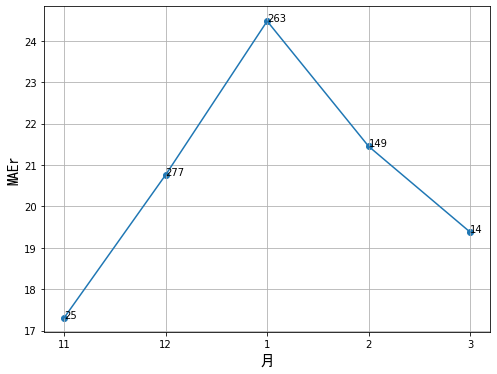

In [161]:
plt.rcParams['figure.figsize'] = [8, 6]
fig, ax = plt.subplots(1, 1)
x = ["11", "12", "1", "2", "3"]
line, = ax.plot(x, MAEs_months)
ax.scatter(x, MAEs_months)
plt.xlabel("月", fontname="MS Gothic",  fontsize=15)
plt.ylabel("MAEr", fontname="MS Gothic",  fontsize=15)

for i, txt in enumerate(lengths):
    plt.annotate(txt, (x[i], MAEs_months[i]))


plt.grid(True)

In [278]:
#椿データ
from sklearn.metrics import confusion_matrix
def shrehold_prediction_tsubaki(df_erro, shrehold):
    df_erro["label"] = ""
    df_erro["pre"] = ""
    for i in range(len(df_erro)):
        if df_erro.loc[i, "タンク容量"] - df_erro.loc[i, "真値(給油量L)"] > df_erro.loc[i, "タンク容量"] * 0.5:
            df_erro.loc[i, "label"] = 0
        else:
            df_erro.loc[i, "label"] = 1
    for i in range(len(df_erro)):
        if df_erro.loc[i, "タンク容量"] - df_erro.loc[i, "予測値"] > df_erro.loc[i, "タンク容量"] * shrehold:
            df_erro.loc[i, "pre"] = 0
        else:
            df_erro.loc[i, "pre"] = 1
    return df_erro
def calculate_confusion_tsubaki(df_erro, shrehold):
    df_erro = shrehold_prediction_tsubaki(df_erro, shrehold)
    s_true = list(df_erro["label"])
    s_pre = list(df_erro["pre"])
    return confusion_matrix(s_true, s_pre)

def shrehold_prediction_appolo(df_erro, shrehold):
    df_erro["label"] = ""
    df_erro["pre"] = ""
    for i in range(len(df_erro)):
        if df_erro.loc[i, "size"] - df_erro.loc[i, "真値(給油量L)"] > df_erro.loc[i, "size"] * 0.5:
            df_erro.loc[i, "label"] = 0
        else:
            df_erro.loc[i, "label"] = 1
    for i in range(len(df_erro)):
        if df_erro.loc[i, "size"] - df_erro.loc[i, "予測値"] > df_erro.loc[i, "size"] * shrehold:
            df_erro.loc[i, "pre"] = 0
        else:
            df_erro.loc[i, "pre"] = 1
    return df_erro
def calculate_confusion_appolo(df_erro, shrehold):
    df_erro = shrehold_prediction_appolo(df_erro, shrehold)
    s_true = list(df_erro["label"])
    s_pre = list(df_erro["pre"])
    return confusion_matrix(s_true, s_pre)

In [279]:
calculate_confusion_appolo(df_erro, 0.5)

array([[440,  43],
       [ 62, 317]], dtype=int64)

In [280]:
calculate_confusion_appolo(df_erro, 0.6)

array([[286, 197],
       [  4, 375]], dtype=int64)

In [281]:
confusion = calculate_confusion_appolo(df_erro, 0.2)
confusion

array([[483,   0],
       [361,  18]], dtype=int64)

In [282]:
calculate_confusion_appolo(df_erro, 0.4)

array([[479,   4],
       [200, 179]], dtype=int64)

In [283]:
Precision = []
Recall = []
TPR = []
FPR = []

for i in np.arange(0.2, 0.8, 0.05):
    confusion = calculate_confusion_appolo(df_erro, i)
    precision = confusion[1][1] / (confusion[0][1] + confusion[1][1])
    recall = confusion[1][1] / (confusion[1][0] + confusion[1][1])
    Precision.append(precision)
    Recall.append(recall)
for i in np.arange(0.2, 0.8, 0.05):
    confusion = calculate_confusion_appolo(df_erro, i)
    FPR.append(confusion[0][1] / (confusion[0][1] + confusion[0][0]))
    TPR.append(confusion[1][1] / (confusion[1][0] + confusion[1][1]))
    Precision.append(precision)
    Recall.append(recall)

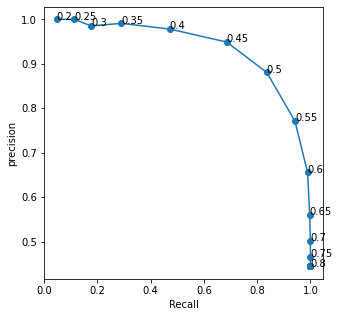

In [284]:
plt.rcParams['figure.figsize'] = [5, 5]
plt.plot(Recall, Precision)
plt.scatter(Recall, Precision)
plt.xlabel("Recall")
plt.ylabel("precision")
n = list(np.round(np.arange(0.2, 0.8, 0.05), 2))
for i, txt in enumerate(n):
    plt.annotate(txt, (Recall[i], Precision[i]))

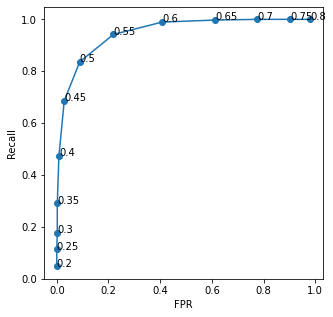

In [285]:
plt.rcParams['figure.figsize'] = [5, 5]
plt.plot(FPR, TPR)
plt.scatter(FPR, TPR)
plt.xlabel("FPR")
plt.ylabel("Recall")
n = list(np.round(np.arange(0.2, 0.8, 0.05), 2))
for i, txt in enumerate(n):
    plt.annotate(txt, (FPR[i], TPR[i]))

In [90]:
df_erro.head()

,id,supplied_at,予測値,真値(給油量L),誤差(予測-真値),EE((予測-真値)/真値),interval,matemp,mltemp,mhtemp,tank_type_id,タンク容量,推定の残量,実際の残量,推定残日数,可能な残日数,残日数EE,label,pre
0,637,2018-02-09 06:17:00,265.7,267.0,-1.3,-0.005,7.0,-3.4,-6.8,-0.2,1,496,230.3,229.0,6.1,6.0,0.017,1,1
1,637,2018-12-07 06:33:00,269.0,264.3,4.7,0.018,10.0,2.1,-1.3,5.2,1,496,227.0,231.7,8.4,8.8,-0.045,1,1
2,637,2018-12-14 07:39:00,253.4,282.9,-29.5,-0.104,7.0,-4.3,-7.3,-2.2,1,496,242.6,213.1,6.7,5.3,0.264,1,1
3,637,2018-12-21 06:19:00,215.6,223.9,-8.3,-0.037,7.0,-0.0,-2.9,2.2,1,496,280.4,272.1,9.1,8.5,0.071,0,1
4,637,2019-01-11 06:45:00,233.2,285.6,-52.4,-0.184,7.0,-2.7,-5.1,-0.2,1,496,262.8,210.4,7.9,5.2,0.519,1,1


In [91]:
dataset.head()

,customer_id,tank_type_id,supplied_at,volume,sum,mean,matemp,mltemp,mhtemp,mwind,msnowacc,msnow,msun,mhumidi,mean_consumption,interval,last_supply_time,last_year_mean,last_year_sum,price
0,637,1,2017-11-20 07:35:00,219.6,5056.6,32.623226,-3.170000,0.170000,-6.900000,3.770000,6.400000,3.600000,3.230000,66.900000,21.960000,10.0,2017-11-10 07:48:00,34.611465,5434.0,77
1,637,1,2017-11-30 07:03:00,296.1,5056.6,32.623226,-0.280000,3.620000,-3.200000,3.420000,10.400000,2.600000,2.260000,69.300000,29.610000,10.0,2017-11-20 07:35:00,34.611465,5434.0,77
2,637,1,2017-12-08 06:47:00,289.1,5056.6,32.623226,2.712500,5.212500,0.350000,2.487500,12.875000,6.250000,3.112500,66.875000,36.137500,8.0,2017-11-30 07:03:00,34.611465,5434.0,81
3,637,1,2017-12-15 07:18:00,248.2,5056.6,32.623226,0.828571,4.071429,-2.200000,2.671429,23.142857,0.571429,3.685714,62.000000,35.457143,7.0,2017-12-08 06:47:00,34.611465,5434.0,81
4,637,1,2017-12-22 06:47:00,266.4,5056.6,32.623226,2.914286,6.185714,0.357143,2.014286,27.000000,2.714286,1.700000,70.714286,38.057143,7.0,2017-12-15 07:18:00,34.611465,5434.0,81


In [92]:
december_index = []
for i in range(len(dataset)):
    if dataset.loc[i, "supplied_at"].month == 1:
        december_index.append(i)

In [93]:
df_december = dataset.iloc[december_index]

In [94]:
df_december.reset_index(inplace=True, drop=True)

In [95]:
december_day = []
for i in range(len(df_december)):
    december_day.append(df_december.loc[i, "supplied_at"].day)

In [96]:
min(december_day)

2

Text(0, 0.5, '給油件数')

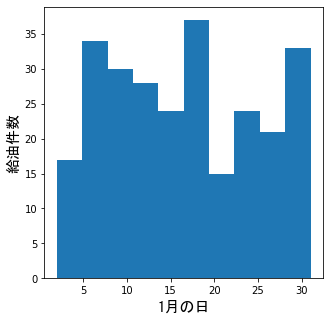

In [97]:
plt.hist(december_day)
plt.xlabel("1月の日",fontname="MS Gothic",  fontsize=15)
plt.ylabel("給油件数", fontname="MS Gothic",  fontsize=15)

In [98]:
danger = []
for i in range(len(df_erro)):
    if df_erro.loc[i, "label"] == 1 and df_erro.loc[i, "pre"] == 0:
        danger.append(i)


In [99]:
df_erro.iloc[danger].to_csv("./unusual_id/FNR.csv", encoding='utf_8_sig')

In [100]:
df_large_error1 = df_erro[df_erro["誤差(予測-真値)"]<=-60]

In [101]:
df_large_error2 = df_erro[df_erro["誤差(予測-真値)"]>60]

In [102]:
df_large_error1["id"]

23      725
24      725
36      725
90      770
115     817
170    1064
180     826
181     826
183     838
187    1070
Name: id, dtype: int64

In [103]:
df_large_error2["id"]

79      624
110    1051
111    1051
146     771
169    1089
196    1095
207     867
217     867
Name: id, dtype: int64

In [104]:
dataset.head()

,customer_id,tank_type_id,supplied_at,volume,sum,mean,matemp,mltemp,mhtemp,mwind,msnowacc,msnow,msun,mhumidi,mean_consumption,interval,last_supply_time,last_year_mean,last_year_sum,price
0,637,1,2017-11-20 07:35:00,219.6,5056.6,32.623226,-3.170000,0.170000,-6.900000,3.770000,6.400000,3.600000,3.230000,66.900000,21.960000,10.0,2017-11-10 07:48:00,34.611465,5434.0,77
1,637,1,2017-11-30 07:03:00,296.1,5056.6,32.623226,-0.280000,3.620000,-3.200000,3.420000,10.400000,2.600000,2.260000,69.300000,29.610000,10.0,2017-11-20 07:35:00,34.611465,5434.0,77
2,637,1,2017-12-08 06:47:00,289.1,5056.6,32.623226,2.712500,5.212500,0.350000,2.487500,12.875000,6.250000,3.112500,66.875000,36.137500,8.0,2017-11-30 07:03:00,34.611465,5434.0,81
3,637,1,2017-12-15 07:18:00,248.2,5056.6,32.623226,0.828571,4.071429,-2.200000,2.671429,23.142857,0.571429,3.685714,62.000000,35.457143,7.0,2017-12-08 06:47:00,34.611465,5434.0,81
4,637,1,2017-12-22 06:47:00,266.4,5056.6,32.623226,2.914286,6.185714,0.357143,2.014286,27.000000,2.714286,1.700000,70.714286,38.057143,7.0,2017-12-15 07:18:00,34.611465,5434.0,81


In [105]:
dataset_for_unusualID = dataset[["customer_id", "supplied_at", "volume", "interval", "matemp", "mltemp", "mhtemp", "tank_type_id"]]

In [106]:
dataset_for_unusualID["matemp"] = -dataset_for_unusualID["matemp"].astype(float).round(1)
dataset_for_unusualID["mltemp"] = -dataset_for_unusualID["mltemp"].astype(float).round(1)
dataset_for_unusualID["mhtemp"] = -dataset_for_unusualID["mhtemp"].astype(float).round(1)

In [107]:
dataset_for_unusualID.head()

,customer_id,supplied_at,volume,interval,matemp,mltemp,mhtemp,tank_type_id
0,637,2017-11-20 07:35:00,219.6,10.0,3.2,-0.2,6.9,1
1,637,2017-11-30 07:03:00,296.1,10.0,0.3,-3.6,3.2,1
2,637,2017-12-08 06:47:00,289.1,8.0,-2.7,-5.2,-0.4,1
3,637,2017-12-15 07:18:00,248.2,7.0,-0.8,-4.1,2.2,1
4,637,2017-12-22 06:47:00,266.4,7.0,-2.9,-6.2,-0.4,1


In [108]:
unusual_id = [725, 1064, 770, 826, 624, 1051]
for id in unusual_id:
    df_raw = dataset_for_unusualID[dataset_for_unusualID["customer_id"] == id]
    df_unusual = df_erro[df_erro["id"]==id]
    df_raw.to_csv("./unusual_id/" + str(id) + "_unusual_id_raw.csv", encoding='utf_8_sig')
    df_unusual.to_csv("./unusual_id/" + str(id)+ "_unusual_id_estimation.csv", encoding='utf_8_sig')


In [115]:
def safe_estimation_percentage(plan_days = 7, EE_shrehold = 0.2, EE_day_shrehold = 0.2):
    safe_estimation = []
    for i in range(len(df_erro)):
        if df_erro.loc[i, "EE((予測-真値)/真値)"] >= -EE_shrehold and df_erro.loc[i, "EE((予測-真値)/真値)"] <= EE_shrehold:
            if  df_erro.loc[i, "可能な残日数"] >= plan_days and df_erro.loc[i, "残日数EE"] >= -EE_day_shrehold and df_erro.loc[i, "残日数EE"] <= EE_day_shrehold:
                safe_estimation.append(i)
            elif df_erro.loc[i, "可能な残日数"] < plan_days and df_erro.loc[i, "残日数EE"] >= -EE_day_shrehold and df_erro.loc[i, "残日数EE"] <=0:
                safe_estimation.append(i)
    return len(safe_estimation) / len(df_erro)


In [116]:
EE_shrehold = 0.1
safe =[]
for i in range(len(df_erro)):
    if df_erro.loc[i, "EE((予測-真値)/真値)"] >= -EE_shrehold and df_erro.loc[i, "EE((予測-真値)/真値)"] <= EE_shrehold:
        safe.append(i)
print(len(safe)/len(df_erro))

0.5619834710743802


In [117]:
safe_plan_days = []
safe_plan_days_p = [7, 8, 9, 10]

safe_EE_shrehold = []
safe_EE_shrehold_p = [0.2, 0.3, 0.4, 0.5]

safe_EE_day_shrehold = []
safe_EE_day_shrehold_p = [0.2, 0.3, 0.4, 0.5]


for i in safe_plan_days_p:
    safe_plan_days.append(safe_estimation_percentage(plan_days = i))
for i in safe_EE_shrehold_p:
    safe_EE_shrehold.append(safe_estimation_percentage(EE_shrehold = i))
for i in safe_EE_day_shrehold_p:
    safe_EE_day_shrehold.append(safe_estimation_percentage(EE_day_shrehold = i))


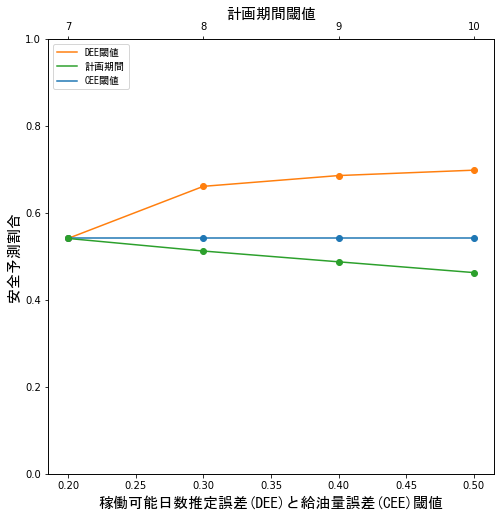

In [118]:
from matplotlib.ticker import MaxNLocator
plt.rcParams['figure.figsize'] = [8, 8]
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

line1, = ax1.plot(safe_EE_day_shrehold_p, safe_EE_day_shrehold, color="#ff7f0e") # orange
ax1.scatter(safe_EE_day_shrehold_p, safe_EE_day_shrehold,color="#ff7f0e")
line3, = ax1.plot(safe_EE_shrehold_p, safe_EE_shrehold, color="#1f77b4")
ax1.scatter(safe_EE_shrehold_p, safe_EE_shrehold,color="#1f77b4")
ax1.set_xlabel("稼働可能日数推定誤差(DEE)と給油量誤差(CEE)閾値", fontname="MS Gothic",fontsize=15)
ax1.set_ylabel("安全予測割合", fontname="MS Gothic",fontsize=15)


line2, = ax2.plot(safe_plan_days_p, safe_plan_days, color="#2ca02c") # Green
ax2.scatter(safe_plan_days_p, safe_plan_days, color="#2ca02c")
ax2.set_xlabel("計画期間閾値", fontname="MS Gothic", fontsize=15)
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.ylim([0, 1])


plt.legend([line1, line2, line3],["DEE閾値","計画期間","CEE閾値"], loc="upper left", prop = {"family" : "MS Gothic"},fontsize=15)


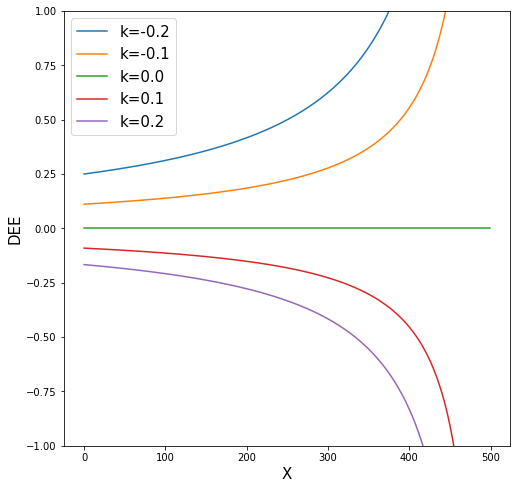

In [82]:
S = 500
K = [-0.2, -0.1, 0.0, 0.1, 0.2]
Z = []
line = []
X = np.arange(500)
fig = plt.figure()
ax = fig.add_subplot(111)
for k in K:
    z = []
    for c in X:
        z.append((-k*S)/((1+k)*(S - c)))
    Z.append(z)
    line.append(ax.plot(X, z)[0])
plt.ylim([-1,1])
ax.set_xlabel("X", fontsize=15)
ax.set_ylabel("DEE", fontsize=15)
plt.legend(line,["k=-0.2","k=-0.1","k=0.0","k=0.1","k=0.2"], loc="upper left",fontsize=15)

In [135]:
df_erro.head()

,予測値,真値(給油量L),誤差(予測-真値),EE((予測-真値)/真値),interval,tank_type_id,タンク容量,推定の残量,実際の残量,推定残日数,可能な残日数,残日数EE
0,265.667297,267.0,-1.332703,-0.004991,7.0,1,496,230.332703,229.0,6.068978,6.003745,0.010865
1,269.007660,264.3,4.707660,0.017812,10.0,1,496,226.99234,231.7,8.438137,8.766553,-0.037462
2,253.380600,282.9,-29.519400,-0.104346,7.0,1,496,242.6194,213.1,6.702707,5.272888,0.271164
3,215.607391,223.9,-8.292609,-0.037037,7.0,1,496,280.392609,272.1,9.103344,8.506923,0.07011
4,233.165833,285.6,-52.434167,-0.183593,7.0,1,496,262.834167,210.4,7.890689,5.156863,0.530134


In [136]:
df_erro_1 = df_erro[df_erro["真値(給油量L)"]<=200]

In [113]:
len(df_erro_1)

100

In [111]:
#df_erro_2 = df_erro[df_erro["真値(給油量L)"]<=400]
df_erro_2 = df_erro[df_erro["真値(給油量L)"]>200]

In [114]:
len(df_erro_2)

142

In [112]:
df_erro_3 = df_erro[df_erro["真値(給油量L)"]>400]

'\nax[2].set_xlim(xlims)\nax[2].set_ylim(ylims)\nax[2].axvline(x=0, color=\'#ff7f0e\', linestyle=\'-\')\nax[2].hist(df_erro_3["誤差(予測-真値)"], bins=20)\nax[2].set_xlabel(\'400-(L)\', fontname="MS Gothic")\n'

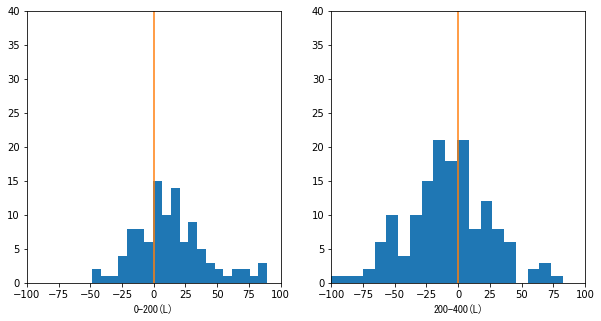

In [233]:
plt.rcParams['figure.figsize'] = [10, 5]
fig, ax = plt.subplots(1,2)

xlims = [-100, 100]
ylims = [0, 40]
ax[0].set_xlim(xlims)
ax[0].set_ylim(ylims)
ax[0].axvline(x=0, color='#ff7f0e', linestyle='-')
ax[0].hist(df_erro_1["誤差(予測-真値)"], bins=20)
ax[0].set_xlabel('0-200(L)', fontname="MS Gothic")

ax[1].set_xlim(xlims)
ax[1].set_ylim(ylims)
ax[1].axvline(x=0, color='#ff7f0e', linestyle='-')
ax[1].hist(df_erro_2["誤差(予測-真値)"], bins=20)
ax[1].set_xlabel('200-400(L)', fontname="MS Gothic")

"""
ax[2].set_xlim(xlims)
ax[2].set_ylim(ylims)
ax[2].axvline(x=0, color='#ff7f0e', linestyle='-')
ax[2].hist(df_erro_3["誤差(予測-真値)"], bins=20)
ax[2].set_xlabel('400-(L)', fontname="MS Gothic")
"""


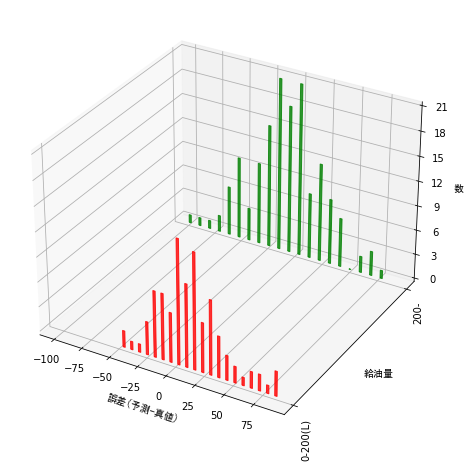

In [234]:
data_histogram_list = [df_erro_1["誤差(予測-真値)"], df_erro_2["誤差(予測-真値)"]]
from matplotlib.ticker import MaxNLocator

plt.rcParams['figure.figsize'] = [8, 8]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
nbins = 20
yticks = [0, 1]
x_ticks_labels = ["0-200(L)","200-"]

for c, z, ys in zip(['r', 'g', 'b'], yticks, data_histogram_list):
    #ys = np.random.normal(loc=10, scale=10, size=2000)


    hist, bins = np.histogram(ys, bins=nbins)
    xs = (bins[:-1] + bins[1:])/2

    ax.bar(xs, hist, zs=z, zdir='y', color=c, ec=c, alpha=0.8,width=2.0)
ax.set_xlabel('誤差(予測-真値)',fontname="MS Gothic")
ax.set_ylabel('給油量',fontname="MS Gothic")
ax.set_zlabel('数', fontname="MS Gothic")
ax.set_yticks(yticks)
ax.set_yticklabels(x_ticks_labels, rotation='vertical')
ax.zaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

In [235]:
sf.error_distribution(df_erro_1["EE((予測-真値)/真値)"])

>-0.2 and <=0: 0.2621359223300971
<0.2 and >0: 0.4854368932038835
>0.2: 0.22330097087378642
<-0.2: 0.02912621359223301


In [236]:
sf.error_distribution(df_erro_2["EE((予測-真値)/真値)"])

>-0.2 and <=0: 0.5333333333333333
<0.2 and >0: 0.36
>0.2: 0.03333333333333333
<-0.2: 0.07333333333333333


In [216]:
sf.error_distribution(df_erro_3["EE((予測-真値)/真値)"])

-0.2~0.2: 0.5
>0.2: 0.0
<-0.2: 0.5


In [ ]:
# model
K.clear_session()
lstmmodel = get_lstm_model_nomask(train_data, 15)

# visualize
# keras.utils.plot_model(model, "my_first_model.png",show_shapes=True)
lstmmodel.summary()

In [ ]:
# train
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, verbose=1, patience=20, min_lr=0.000001)
history = lstmmodel.fit(padded_train, train_label, epochs=100, batch_size=5,
        shuffle=True, validation_split=0.0123456789,
        callbacks=[reduce_lr])

# save weights
lstmmask = []
for i in [2,3,5,6]:
    w = lstmmodel.get_layer(index=i).get_weights()
    lstmmask.append(w)